# **ALFA dataset Anomaly Classificataion using Mcfly module reference, torch, Window size 60**

**Anomaly Classification using CNN**

<!-- ## **Setup Dependencies** -->

In [1]:
import os
import sys
import json
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
from collections import Counter
# from sktime.datatypes import convert_to
from timeit import default_timer as timer
#from sktime.datasets import load_from_tsfile
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
#from sktime.datasets import load_from_tsfile_to_dataframe
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
# from mcfly.modelgen import generate_models
# from mcfly.find_architecture import find_best_architecture
# from mcfly.find_architecture import train_models_on_samples
from tensorflow.keras.metrics import AUC
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
import torch

warnings.filterwarnings('ignore')
np.random.seed(42)

## **Load Dataset**

The given size (N, seq_len, features) applicable for mcfly

In [4]:
# no rolling stats
X = np.load('/kaggle/input/alfa-complete-windowsz-60/ALFA_seq_windows_60/alfa_dataset_complete_sequence_X_windows_60.npy')
y = np.load('/kaggle/input/alfa-complete-windowsz-60/ALFA_seq_windows_60/alfa_dataset_complete_sequence_y_windows_60.npy')
print(X.shape)
print(y.shape)

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/alfa-complete-windowsz-60/ALFA_seq_windows_60/alfa_dataset_complete_sequence_X_windows_60.npy'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# no rolling stats
from google.colab import files
uploaded = files.upload()

Saving alfa_dataset_sequence_X.npy to alfa_dataset_sequence_X.npy


In [ ]:
uploaded


Buffered data was truncated after reaching the output size limit.

**Swapaxes, output shape (N,features,seq_len), its required for pytorch**

In [ ]:
X = np.swapaxes(X, 1, 2)
X.shape

(3604, 17, 60)

#### **Z-score normalize**

In [ ]:
mean = np.mean(X, axis=(0,2), keepdims=True)
std = np.std(X, axis=(0, 2), keepdims=True)
X_norm = (X - mean) / std
print(X_norm.shape)

(3604, 17, 60)


**Label encoding**

Applicable for mcfly only

In [ ]:
ohe = OneHotEncoder()

y = ohe.fit_transform(y.reshape(-1, 1)).toarray()
y.shape

(2792, 2)

## **Train valid test split**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.10, random_state=40,
                                                    shuffle=True, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size=0.10, random_state=40,
                                                  shuffle=True, stratify=y_train)

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(2918, 17, 60) (325, 17, 60) (361, 17, 60)
(2918,) (325,) (361,)


## **Inception Network for TImeseries**

In [ ]:
# import dependencies
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight


**Dataset**

In [ ]:
# setup
batch_size = 32
seq_length = 40
num_features = 17
num_classes = 5

# train
X_train_tensor = torch.tensor(X_train).to(torch.float32)
y_train_tensor = torch.tensor(y_train).to(torch.int64)

# valid
X_val_tensor = torch.tensor(X_val).to(torch.float32)
y_val_tensor = torch.tensor(y_val).to(torch.int64)

# test
X_test_tensor = torch.tensor(X_test).to(torch.float32)
y_test_tensor = torch.tensor(y_test).to(torch.int64)


print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)


# dataloader

#train
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#train_dataset, val_dataset, test = random_split(TensorDataset(X_tensor, y_tensor), [train_size, val_size])

#valid
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

#test
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# for data in train_loader:
#     print(data[0].shape, data[1].shape, data[1].shape, data[1].dtype)


(2918, 17, 60) (2918,)
(325, 17, 60) (325,)
(361, 17, 60) (361,)


#### **Torch implementation of Model for windowsz=60**

In [ ]:
# SPATIAL ATTENTION LAYER
class SpatialAttention1D(nn.Module):
    # deafault kernel size 7
    def __init__(self, kernel_size=7):
        super(SpatialAttention1D, self).__init__()
        self.conv1 = nn.Conv1d(2, 1, kernel_size=kernel_size, padding=(kernel_size-1)//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

# channel attention block
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, ratio=8):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.max_pool = nn.AdaptiveMaxPool1d(1)

        self.fc1 = nn.Conv1d(in_channels, in_channels // ratio, kernel_size=1, bias=False)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Conv1d(in_channels // ratio, in_channels, kernel_size=1, bias=False)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return self.sigmoid(out)

# Inception Block
class InceptionModule1D(nn.Module):
    def __init__(self, in_channels):
        super(InceptionModule1D, self).__init__()

        # introduce conv1d inception block to reduce dimensionality for the first time
        self.cnn = nn.Conv1d(in_channels, 32, kernel_size = 1)

        self.branch1x1 = nn.Conv1d(32, 76, kernel_size=1)
        self.branch1x1 = nn.Conv1d(32, 76, kernel_size=1)

        self.branch3x3 = nn.Sequential(
            nn.Conv1d(32, 76, kernel_size=15, padding=7),
            nn.Conv1d(76, 76, kernel_size=15, padding=7)
        )

        self.branch5x5 = nn.Sequential(
            nn.Conv1d(32, 76, kernel_size=31, padding=15),
            nn.Conv1d(76, 76, kernel_size=31, padding=15)
        )

        # output channel from inception layer is 64
        self.branch_pool = nn.Sequential(
            nn.Conv1d(in_channels, 76, kernel_size=1),
        )

    def forward(self, x):
        cnn = self.cnn(x)

        branch1x1 = self.branch1x1(cnn)

        branch3x3 = self.branch3x3(cnn)

        branch5x5 = self.branch5x5(cnn)

        branch_pool = F.avg_pool1d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = torch.cat([branch1x1, branch3x3, branch5x5, branch_pool], dim=1)
        return outputs

class InceptionTimeSeriesClassifier(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(InceptionTimeSeriesClassifier, self).__init__()
        self.inception_out = 304
        # bat_norm for input channels
        self.bn1 = nn.BatchNorm1d(in_channels)
        self.inception1 = InceptionModule1D(in_channels)

        self.bn2 = nn.BatchNorm1d(self.inception_out)
        # add activation
        self.relu2 = nn.ReLU()
        self.inception2 = InceptionModule1D(self.inception_out)  # 64*4

        self.bn3 = nn.BatchNorm1d(self.inception_out)
        # add activation
        self.relu3 = nn.ReLU()
        self.inception3 = InceptionModule1D(self.inception_out)

        self.bn4 = nn.BatchNorm1d(self.inception_out)
        # add activation
        self.relu4 = nn.ReLU()
        self.inception4 = InceptionModule1D(self.inception_out)  # 64*4

        self.bn4 = nn.BatchNorm1d(self.inception_out)
        # add activation
        self.relu4 = nn.ReLU()
        self.inception5 = InceptionModule1D(self.inception_out)

        self.bn5 = nn.BatchNorm1d(self.inception_out)
        # add activation
        self.relu5 = nn.ReLU()

        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(self.inception_out, num_classes)
        # channel attention layer
        self.channel_attention = ChannelAttention(self.inception_out)
        # spatial attention layer
        self.attention = SpatialAttention1D()


    def forward(self, x):
        x = self.bn1(x)
        x = self.inception1(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.inception2(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.inception3(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.inception4(x)
        x = self.bn5(x)
        x = self.relu5(x)

        self.feature_maps = x
        attention_weights = self.attention(x)
        x = x * attention_weights

        #x = self.global_pool(x)
        #x = x.view(x.size(0), -1)
        #x = self.inception4(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


# Training loop with validation
#def train_model(model, train_loader, val_loader, class_weights, num_epochs=10, learning_rate=0.001, save_path='best_model.pth'):
def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001, save_path='best_model.pth', patience=20):
    #criterion = nn.CrossEntropyLoss(weight=class_weights)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # variable for earlystopping
    patience_counter = 0
    # LE scheduler
    #scheduler = torch.optim.ReduceLROnPlateau(optimizer, 'min')

    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            #print(y_batch.shape, y_batch.dtype)
            #print(outputs.shape, outputs.dtype)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X_batch.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)

        # Validation step
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                outputs = model(X_val)
                loss = criterion(outputs, y_val)
                val_loss += loss.item() * X_val.size(0)
        val_loss /= len(val_loader.dataset)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}')

        # Note that step should be called after validate()
        #scheduler.step(val_loss)

        # Save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), save_path)
            print(f'Saved best model with validation loss: {val_loss:.4f}')
#         else:
#             patience_counter += 1
#             if patience_counter >= patience:
#                 print("Early stopping")
#                 break


batch_size = 32
seq_length = 60
num_features = 17
num_classes = 5

# define the inception model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Compute class weights based on actual class distribution y
#class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
#class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

model = InceptionTimeSeriesClassifier(in_channels=num_features, num_classes=num_classes).to(device)
model


InceptionTimeSeriesClassifier(
  (bn1): BatchNorm1d(17, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (inception1): InceptionModule1D(
    (cnn): Conv1d(17, 32, kernel_size=(1,), stride=(1,))
    (branch1x1): Conv1d(32, 76, kernel_size=(1,), stride=(1,))
    (branch3x3): Sequential(
      (0): Conv1d(32, 76, kernel_size=(15,), stride=(1,), padding=(7,))
      (1): Conv1d(76, 76, kernel_size=(15,), stride=(1,), padding=(7,))
    )
    (branch5x5): Sequential(
      (0): Conv1d(32, 76, kernel_size=(31,), stride=(1,), padding=(15,))
      (1): Conv1d(76, 76, kernel_size=(31,), stride=(1,), padding=(15,))
    )
    (branch_pool): Sequential(
      (0): Conv1d(17, 76, kernel_size=(1,), stride=(1,))
    )
  )
  (bn2): BatchNorm1d(304, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (inception2): InceptionModule1D(
    (cnn): Conv1d(304, 32, kernel_size=(1,), stride=(1,))
    (branch1x1): Conv1d(32, 76, kernel_size=(1,), stride=(1,))
   

#### **Model Training**

In [ ]:
#     X, y = generate_data(1000, seq_length, num_features, num_classes)

#     # Splitting data into train and validation sets
#     train_size = int(0.8 * len(X))
#     val_size = len(X) - train_size
#     train_dataset, val_dataset = random_split(TensorDataset(X, y), [train_size, val_size])

#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#     val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Train the model with validation
#train_model(model, train_loader, val_loader, class_weights, num_epochs=100)
train_model(model, train_loader, val_loader, num_epochs=150)


Epoch [1/150], Loss: 1.0357, Validation Loss: 0.9762
Saved best model with validation loss: 0.9762
Epoch [2/150], Loss: 0.9067, Validation Loss: 0.8182
Saved best model with validation loss: 0.8182
Epoch [3/150], Loss: 0.7729, Validation Loss: 0.7254
Saved best model with validation loss: 0.7254
Epoch [4/150], Loss: 0.6735, Validation Loss: 0.5974
Saved best model with validation loss: 0.5974
Epoch [5/150], Loss: 0.5781, Validation Loss: 0.5319
Saved best model with validation loss: 0.5319
Epoch [6/150], Loss: 0.4767, Validation Loss: 0.4138
Saved best model with validation loss: 0.4138
Epoch [7/150], Loss: 0.4198, Validation Loss: 0.2688
Saved best model with validation loss: 0.2688
Epoch [8/150], Loss: 0.3830, Validation Loss: 0.2151
Saved best model with validation loss: 0.2151
Epoch [9/150], Loss: 0.3049, Validation Loss: 0.2148
Saved best model with validation loss: 0.2148
Epoch [10/150], Loss: 0.2654, Validation Loss: 0.2036
Saved best model with validation loss: 0.2036
Epoch [11

#### **Evaluation**

In [ ]:
# Evaluate model and plot confusion matrix
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for X_test, y_test in test_loader:
            X_test, y_test = X_test.to(device), y_test.to(device)
            outputs = model(X_test)
            _, preds = torch.max(outputs, 1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(y_test.cpu().numpy())
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    cm = confusion_matrix(all_labels, all_preds)
    print(classification_report(all_labels, all_preds))

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

**Confusion Matrix, for Spatial Inception Network, in case loading from best model saved weight**

In [ ]:
# laod best model
model.load_state_dict(torch.load("/kaggle/working/best_model.pth"))

<All keys matched successfully>

**With Spatial Attention windows=60**

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       247
           1       1.00      0.91      0.95        11
           2       1.00      1.00      1.00        35
           3       1.00      1.00      1.00        34
           4       1.00      1.00      1.00        34

    accuracy                           1.00       361
   macro avg       1.00      0.98      0.99       361
weighted avg       1.00      1.00      1.00       361



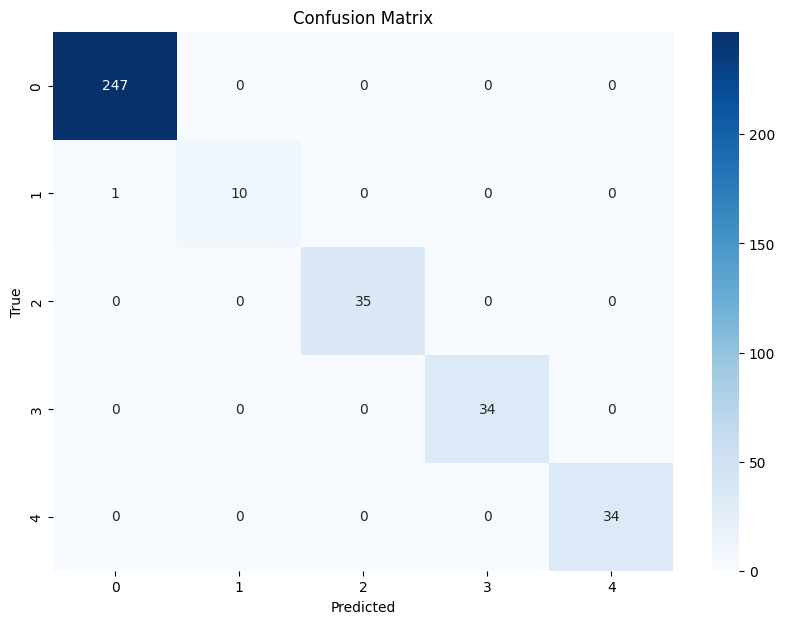

In [ ]:
evaluate_model(model, test_loader)

**Without Spatial Attention windows=60**

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       247
           1       1.00      0.91      0.95        11
           2       0.97      0.94      0.96        35
           3       0.91      0.91      0.91        34
           4       0.89      1.00      0.94        34

    accuracy                           0.98       361
   macro avg       0.95      0.95      0.95       361
weighted avg       0.98      0.98      0.98       361



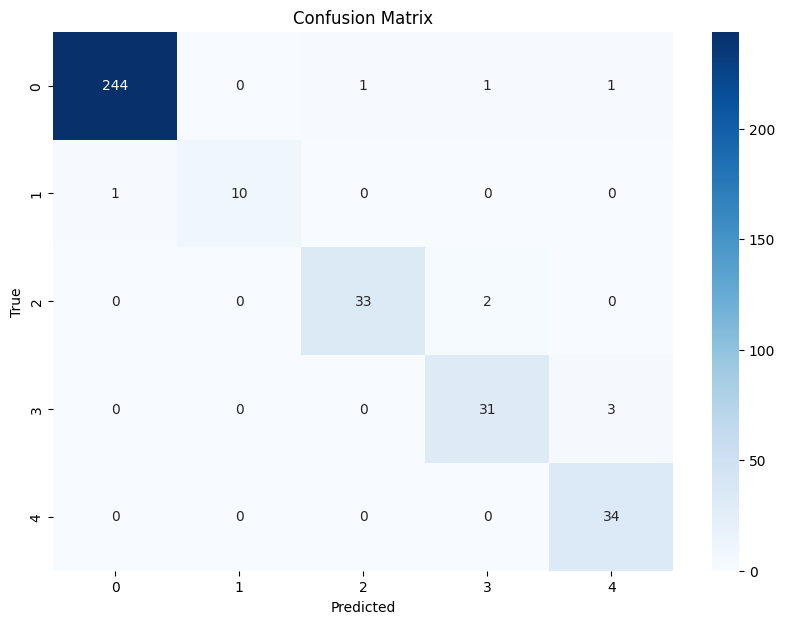

In [ ]:
evaluate_model(model, test_loader)

## **Zipping**

In [ ]:
import zipfile
import os
from IPython.display import FileLink

def zip_dir(directory = os.curdir, file_name = 'directory.zip'):
    """
    zip all the files in a directory

    Parameters
    ___
    directory: str
        directory needs to be zipped, defualt is current working directory

    file_name: str
        the name of the zipped file (including .zip), default is 'directory.zip'

    Returns
    ___
    Creates a hyperlink, which can be used to download the zip file)
    """
    os.chdir(directory)
    zip_ref = zipfile.ZipFile(file_name, mode='w')
    for folder, _, files in os.walk(directory):
        for file in files:
            if file_name in file:
                pass
            else:
                zip_ref.write(os.path.join(folder, file))

    return FileLink(file_name)

In [ ]:
zip_dir(file_name = 'ALFA_experiment_jul_21_acc_99_windows_60_Inception_Spatial_GradCam.zip')

/kaggle/working/ALFA_experiment_jul_21_acc_99_windows_60_Inception_Spatial_GradCam.zip

# **GradCAM Check**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        self.hook_handles = []
        self.hook_handles.append(target_layer.register_forward_hook(self.save_activations))
        self.hook_handles.append(target_layer.register_backward_hook(self.save_gradients))

    def save_activations(self, module, input, output):
        self.activations = output

    def save_gradients(self, module, grad_in, grad_out):
        self.gradients = grad_out[0]

    def __call__(self, input_tensor, target_class):
        self.model.eval()

        # Forward pass
        output = self.model(input_tensor)
        target = torch.tensor([target_class]*input_tensor.size(0)).to(input_tensor.device)
        loss = F.cross_entropy(output, target)

        # Backward pass
        self.model.zero_grad()
        loss.backward()

        # Check if activations and gradients are properly captured
        assert self.activations is not None, "Forward hook didn't capture activations."
        assert self.gradients is not None, "Backward hook didn't capture gradients."

        # Get the feature maps and gradients
        feature_maps = self.activations.detach().cpu().numpy()
        grads = self.gradients.detach().cpu().numpy()

        # Compute the weights
        weights = np.mean(grads, axis=2, keepdims=True)

        # Compute Grad-CAM
        gradcams = []
        for i in range(feature_maps.shape[0]):
            gradcam = np.zeros(feature_maps.shape[2:], dtype=np.float32)
            for j, w in enumerate(weights[i]):
                gradcam += w * feature_maps[i, j]
            gradcam = np.maximum(gradcam, 0)
            gradcam = (gradcam - gradcam.min()) / (gradcam.max() - gradcam.min() + 1e-8)
            gradcams.append(gradcam)

        return gradcams

    def remove_hooks(self):
        for handle in self.hook_handles:
            handle.remove()



def plot_gradcam(gradcam, input_signal, seq_length=60):
    num_features = gradcam.shape[0]

    plt.figure(figsize=(15, num_features * 3))

    for feature in range(num_features):
        plt.subplot(num_features, 2, 2*feature + 1)
        plt.plot(np.arange(seq_length), input_signal[:, feature], label=f'Feature {feature}')
        plt.title(f'Input Signal - Feature {feature}')
        plt.xlabel('Time Step')
        plt.ylabel('Amplitude')

        # Check the gradcam shape
        print(f"GradCAM shape for feature {feature}: {gradcam[feature].shape}")

        # Plot Grad-CAM heatmap for each feature
        plt.subplot(num_features, 2, 2*feature + 2)
        if gradcam[feature].ndim == 2:
            plt.imshow(gradcam[feature], aspect='auto', cmap='jet', interpolation='none', extent=[0, seq_length, 0, gradcam[feature].shape[0]])
        elif gradcam[feature].ndim == 1:
            plt.imshow(gradcam[feature].reshape(1, -1), aspect='auto', cmap='jet', interpolation='none', extent=[0, seq_length, 0, 1])
        else:
            raise ValueError("Unexpected gradcam shape")
        plt.title(f'Grad-CAM - Feature {feature}')
        plt.colorbar()
        plt.xlabel('Time Step')
        plt.ylabel('Channel')

    plt.tight_layout()
    plt.show()


def test_with_gradcam(model, test_loader, target_layer, target_class, num_samples=5):
    gradcam = GradCAM(model, target_layer)

    model.eval()
    device = next(model.parameters()).device

    sample_count = 0
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Compute Grad-CAM for the batch
        gradcam_maps = gradcam(X_batch, target_class)

        for i in range(X_batch.size(0)):
            if sample_count >= num_samples:
                gradcam.remove_hooks()
                return

            # Convert tensors to numpy arrays for plotting
            input_signal = X_batch[i].cpu().numpy()
            gradcam_map = gradcam_maps[i]

            # Ensure gradcam_map has expected dimensions
            print(f"GradCAM Map Shape: {gradcam_map.shape}")
            print(f"Input Signal Shape: {input_signal.shape}")

            # Check and handle dimension mismatch
            if gradcam_map.ndim == 1:
                gradcam_map = gradcam_map.reshape((1, -1))

            plot_gradcam(gradcam_map, input_signal, seq_length=X_batch.size(1))
            sample_count += 1

    gradcam.remove_hooks()


GradCAM Map Shape: (60,)
Input Signal Shape: (17, 60)
GradCAM shape for feature 0: (60,)


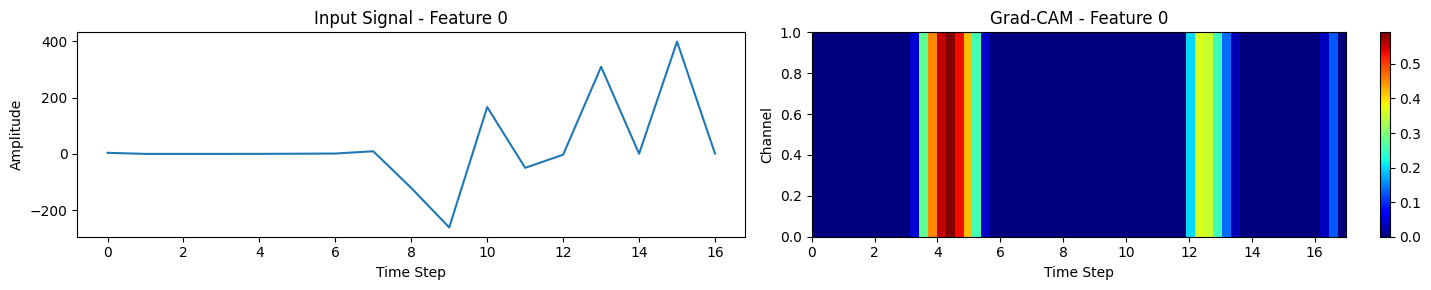

GradCAM Map Shape: (60,)
Input Signal Shape: (17, 60)
GradCAM shape for feature 0: (60,)


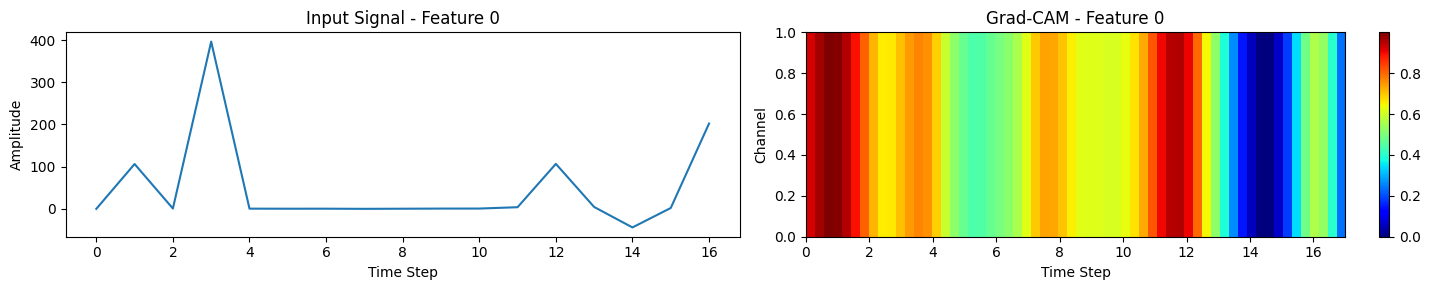

GradCAM Map Shape: (60,)
Input Signal Shape: (17, 60)
GradCAM shape for feature 0: (60,)


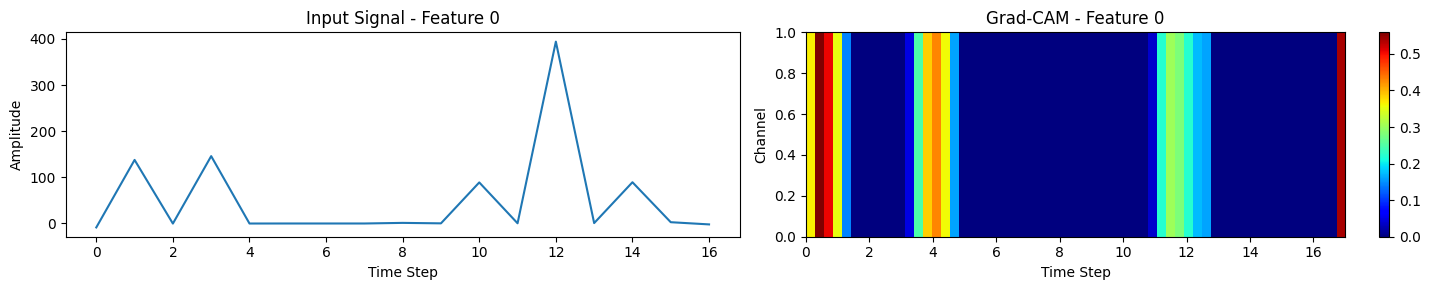

GradCAM Map Shape: (60,)
Input Signal Shape: (17, 60)
GradCAM shape for feature 0: (60,)


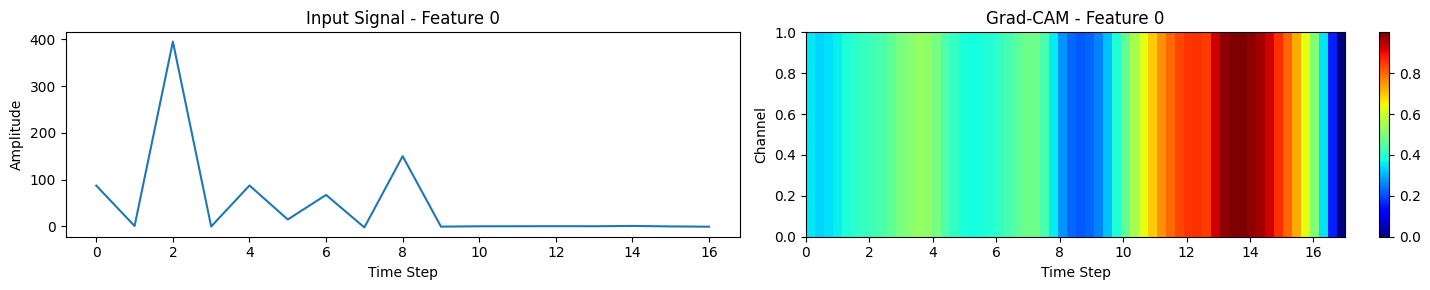

GradCAM Map Shape: (60,)
Input Signal Shape: (17, 60)
GradCAM shape for feature 0: (60,)


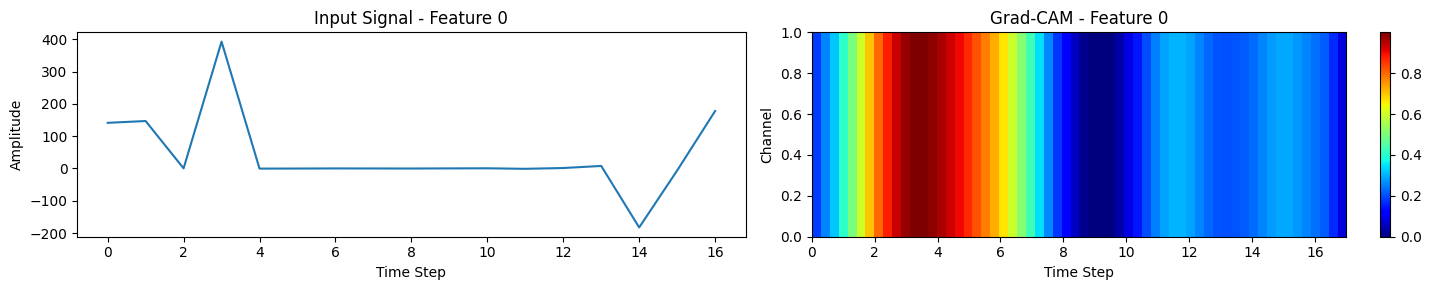

In [ ]:

# Example usage
#test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
target_layer = model.bn5
target_class = 0  # Change to the class you are interested in visualizing

test_with_gradcam(model, test_loader, target_layer, target_class, num_samples=5)


--THE END--